# Bike sharing in Washington
<em>Group Project Statistical Programming in Python<em>
___

                              Master in Business Analytics & Big data
                                    Professor Jorge Lopez Lazaro
                                             Group D
                                            _________

# Table of content

1. Introduction
2. Libraries used
3. Data loading
4. Preparation for baseline
        I) Correct data types
        II) Normalization
        III) Fix Skewness
        IV) One hot encoding
5. Splitting dataset
6. Feature Engineering
        I) Quantile bins
        II) One hot encoding
7. Ensembling
        I) Splitted scoring for Casual and Registered
            a) Registered scoring
            b) Casual scoring
            c) Ensemble scoring
            d) Plotting results
        II) Splitted scoring for Casual/Registered and Workday/Weekend
            a) Registered workday
            b) Registered weekend
            c) Casual workday
            d) Casual weekend
            e) Ensemble scoring
            f) Plotting results
8. Conclusion

# 1. Introduction

### Scope
This study aims to predict the total number of bike sharing users in Washington  on an hourly basis in the last quarter of 2012. This demand prediction of a time series will be measured with the R2 metric in order to see how much of our final model will encompass the information to represent our model. Along the way we measure MSE and MAE in order to not bring an error too large into the models and make strong predictions. 

# 2. Libraries used

In [2]:
import pandas as pd
import numpy as np
import warnings

from collections import defaultdict
from sklearn import metrics

from sklearn import preprocessing
from sklearn import clone
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn import model_selection

from scipy import stats

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import explained_variance_score

warnings.simplefilter(action='ignore')

# 3. Data Loading
The dataset can be accessed at the following website:
https://www.kaggle.com/marklvl/bike-sharing-dataset
The file is downloaded and loaded in a gist, so it can be loaded into the python script when you are conected to the internet. In addition, we found the dataset of all Bike Sharing Stations Capital Bike Sharing runs. We wil run exploratory location analysis on it in order to discover patterns in the data.

In [71]:
hour_data = pd.read_csv(
    "https://gist.githubusercontent.com/geraldwal/b5a83f4c670abe0a662abce558e5d433/raw/bce4bbfc63355606e4503964e25798b5d2190b9b/hour%2520-%2520Python%2520Bike%2520Sharing",
    sep=",",
    parse_dates=["dteday"],
)

Renaming columns of the dataset we will use for modelling.

In [79]:
hour_data.rename(
    columns={
        "weathersit": "weather",
        "mnth": "month",
        "hr": "hour",
        "hum": "humidity",
        "cnt": "count",
        "yr": "year",
    },
    inplace=True,
)

Copying the dataset to later be able to use the parsed date information.

In [100]:
first_hour_data=hour_data

To have all needed values included, we extracted the day column from the dteday variable.

In [5]:
hour_data.dteday = pd.to_datetime(hour_data.dteday, format="%Y-%m-%d")
hour_data["day"] = pd.DatetimeIndex(hour_data["dteday"]).day
display(hour_data.head(2))

,instant,dteday,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1


When analyzing the variables further, we realized that the season column includes misleading information as shown below, therefore we adjusted it to the real seasons (from: https://en.wikipedia.org/wiki/Season).

In [6]:
print(hour_data.groupby("season").apply(lambda x: x["month"].unique()))

season
1      [1, 2, 3, 12]
2       [3, 4, 5, 6]
3       [6, 7, 8, 9]
4    [9, 10, 11, 12]
dtype: object


In [7]:
hour_data["season"] = (pd.DatetimeIndex(hour_data["dteday"]).month % 12 + 3) // 3
print(hour_data.groupby("season").apply(lambda x: x["month"].unique()))

season
1     [1, 2, 12]
2      [3, 4, 5]
3      [6, 7, 8]
4    [9, 10, 11]
dtype: object


In [8]:
hour_data.drop(["dteday"], axis=1, inplace=True)

# 4. Preparation for Baseline

## I) Correct data types

In [9]:
hour_data["season"] = hour_data.season.astype("category")
hour_data["month"] = hour_data.month.astype("category")
hour_data["hour"] = hour_data.hour.astype("category")
hour_data["holiday"] = hour_data.holiday.astype("category")
hour_data["weekday"] = hour_data.weekday.astype("category")
hour_data["workingday"] = hour_data.workingday.astype("category")
hour_data["weather"] = hour_data.weather.astype("category")
hour_data["year"] = hour_data.weather.astype("category")
hour_data.dtypes

instant          int64
season        category
year          category
month         category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
day              int64
dtype: object

## II) Normalize

In [10]:
hour_data_norm_subset = hour_data.loc[:, "temp":"windspeed"]

hour_data2 = preprocessing.normalize(hour_data_norm_subset)

hour_data3 = pd.DataFrame(hour_data2)

hour_data3.columns = ["temp", "atemp", "humidity", "windspeed"]

hour_data["temp"] = hour_data3["temp"]
hour_data["temp"] = hour_data3["atemp"]
hour_data["windspeed"] = hour_data3["windspeed"]
hour_data["humidity"] = hour_data3["humidity"]
display(hour_data.head(2))

,instant,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,1,1,1,0,0,6,0,1,0.322571,0.2879,0.907546,0.0,3,13,16,1
1,2,1,1,1,1,0,6,0,1,0.312241,0.2727,0.915998,0.0,8,32,40,1


## III) Fix Skewness

The skewness of the float variables are fixed

In [11]:
def feature_skewness(df):
    numeric_dtypes = ["int64", "float64"]
    numeric_features = []
    for i in df.columns:
        if df[i].dtypes in numeric_dtypes:
            numeric_features.append(i)

    feature_skew = (
        df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    )
    skews = pd.DataFrame({"skew": feature_skew})
    return feature_skew, numeric_features


def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index

    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

    skew_features = (
        df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    )
    skews = pd.DataFrame({"skew": skew_features})
    return df


fix_skewness(hour_data)
hour_data.head()

,instant,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,1,1,1,0,0,6,0,1,0.322571,0.2879,0.907546,0.0,1.514787,4.290997,4.889385,1
1,2,1,1,1,1,0,6,0,1,0.312241,0.2727,0.915998,0.0,2.531634,6.753603,7.720329,1
2,3,1,1,1,2,0,6,0,1,0.312241,0.2727,0.915998,0.0,2.010221,6.224045,6.937960,1
3,4,1,1,1,3,0,6,0,1,0.343375,0.2879,0.894515,0.0,1.514787,3.719130,4.375614,1
4,5,1,1,1,4,0,6,0,1,0.343375,0.2879,0.894515,0.0,0.000000,0.782406,0.786040,1


## IV) One hot encoding

In [12]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns


def categorical_features(df):
    numerical_columns = numerical_features(df)
    return list(set(df.columns) - set(numerical_columns))


def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat(
            [new_df, pd.get_dummies(df[categorical_column], prefix=categorical_column)],
            axis=1,
        )
    return new_df


def onehot_encode_single(df, col_to_encode, drop=True):
    if type(col_to_encode) != str:
        raise TypeError("col_to_encode should be a string.")
    new_df = df.copy()

    if drop == True:
        new_df = new_df.drop([col_to_encode], axis=1)

    new_df = pd.concat(
        [new_df, pd.get_dummies(df[col_to_encode], prefix=col_to_encode)], axis=1
    )
    return new_df

We take a copy before hot encoding to be used later after FE.

In [13]:
hour_data_cl = hour_data.copy()

### One hot encoding for baseline

In [14]:
hour_data_cl_hot_encoded = onehot_encode(hour_data)

Renaming the onehot encoded variables into understandble variable names for the data scientist.

In [15]:
hour_data_cl_hot_encoded.rename(
    columns={
        "holiday_0": "no_holiday",
        "holiday_1": "yes_holiday",
        "month_1": "jan",
        "month_2": "feb",
        "month_3": "mar",
        "month_4": "apr",
        "month_5": "may",
        "month_6": "jun",
        "month_7": "jul",
        "month_8": "aug",
        "month_9": "sep",
        "month_10": "oct",
        "month_11": "nov",
        "month_12": "dec",
        "weekday_0": "sun",
        "weekday_1": "mon",
        "weekday_2": "tue",
        "weekday_3": "wed",
        "weekday_4": "thu",
        "weekday_5": "fri",
        "weekday_6": "sat",
        "season_1": "winter",
        "season_2": "spring",
        "season_3": "summer",
        "season_4": "autumn",
    },
    inplace=True,
)


# 5. Splitting the Dataset

In [93]:
def split_data(dataset, Target):
    X = dataset.loc[:, dataset.columns != Target]
    y = dataset.loc[:, Target]
    train_size = int(len(dataset) * 0.875)
    X_train, X_test, y_train, y_test = (
        X[0:train_size],
        X[train_size : len(dataset)],
        y[0:train_size],
        y[train_size : len(dataset)],
    )
    return X_train, X_test, y_train, y_test

In [22]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = split_data(hour_data_cl_hot_encoded, "registered")
x_train_casual, x_test_casual, y_train_casual, y_test_casual = split_data(hour_data_cl_hot_encoded, "casual")
x_train_count, x_test_count, y_train_count, y_test_count = split_data(hour_data_cl_hot_encoded, "count")

In [23]:
def score_lin(X_train, X_test, y_train, y_test):
    lm = linear_model.LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    print("Intercept:", lm.intercept_)
    print("Coefficients:", lm.coef_)
    print("Mean squared error (MSE): {:.2f}".format(mean_squared_error(y_test, y_pred)))
    print("Variance score (R2): {:.2f}".format(r2_score(y_test, y_pred)))
    return y_pred

In [24]:
##  baseline predictions and score for count
train_dropped_target = x_train_count.drop(["casual", "registered"], axis = 1)
test_dropped_target = x_test_count.drop(["casual", "registered"], axis = 1)
baseline_registered_count = score_lin(train_dropped_target, test_dropped_target, y_train_count, y_test_count)

Intercept: 8.158560480006036
Coefficients: [ 3.18182307e-04  1.83112111e+00  4.53696218e+00 -2.59161264e+00
 -1.77207409e+00 -3.76929155e-03  3.00210674e-01 -3.00210674e-01
 -4.62540170e+00 -6.51925891e+00 -7.72682868e+00 -9.12726260e+00
 -9.90317829e+00 -7.50759588e+00 -3.14159134e+00  1.88204277e+00
  5.70168194e+00  2.87519001e+00  9.93487316e-01  1.74687067e+00
  2.91185508e+00  2.77982631e+00  2.29146136e+00  2.56930939e+00
  4.31176662e+00  7.55210757e+00  6.98883403e+00  4.78172192e+00
  2.68851657e+00  1.11996723e+00 -3.27568749e-01 -2.31595264e+00
  6.03922186e-01  4.57337551e-01 -7.83756980e-01 -2.77502758e-01
  6.03922186e-01  4.57337551e-01 -7.83756980e-01 -2.77502758e-01
 -6.95565553e-02  6.95565553e-02 -8.50034989e-02  4.18641646e-02
 -3.77571149e-01  1.02081914e-01  6.81057827e-01  4.62584967e-01
 -3.10661907e-01 -1.09545049e-01  2.83783045e-01  2.97440131e-01
 -4.28420349e-01 -5.57610095e-01 -9.96656419e-02 -2.11194240e-01
 -2.05938917e-01 -1.39162967e-01 -1.12502264e-0

In [25]:
##  baseline predictions and score for registered
train_dropped_target = x_train_reg.drop(["casual", "count"], axis = 1)
test_dropped_target = x_test_reg.drop(["casual", "count"], axis = 1)
baseline_registered_pred = score_lin(train_dropped_target, test_dropped_target, y_train_reg, y_test_reg)

Intercept: 6.308753294215782
Coefficients: [ 2.94752512e-04  2.69777301e+00  2.51926161e+00 -1.24720376e+00
 -6.19853899e-01 -2.38177652e-03  2.89324674e-01 -2.89324674e-01
 -4.08723741e+00 -5.82464211e+00 -6.92077531e+00 -8.12704054e+00
 -8.78006249e+00 -6.39739039e+00 -2.34661081e+00  2.25169018e+00
  5.71912166e+00  2.78713354e+00  4.64863918e-01  1.03020769e+00
  2.17875604e+00  1.98999913e+00  1.38241156e+00  1.71491771e+00
  3.58766626e+00  6.80854536e+00  6.45497943e+00  4.43509546e+00
  2.56924652e+00  1.18026524e+00 -1.34656063e-01 -1.93648455e+00
  4.85110909e-01  3.87988725e-01 -6.60881803e-01 -2.12217831e-01
  4.85110909e-01  3.87988725e-01 -6.60881803e-01 -2.12217831e-01
 -4.09688278e-01  4.09688278e-01 -3.65900027e-02  8.55732469e-02
 -3.72460689e-01  6.36303984e-03  5.65989403e-01  4.20061750e-01
 -2.40330266e-01 -9.93393161e-02  2.44949614e-01  2.03079236e-01
 -3.23242808e-01 -4.54053209e-01 -2.61568120e-01 -2.12501882e-01
 -7.38119064e-02  2.35903830e-02  1.26380389e-0

In [26]:
##  baseline predictions and score for casual
train_dropped_target = x_train_casual.drop(["registered", "count"], axis = 1)
test_dropped_target = x_test_casual.drop(["registered", "count"], axis = 1)
baseline_casual_pred = score_lin(train_dropped_target, test_dropped_target, y_train_casual, y_test_casual)

Intercept: 1.9298963792598376
Coefficients: [ 4.82403221e-05  8.42263344e-01  2.62793758e+00 -1.04030974e+00
 -9.28416981e-01  1.99431491e-04  3.22043172e-02 -3.22043172e-02
 -9.33215163e-01 -1.45033887e+00 -1.80112343e+00 -2.27608992e+00
 -2.59360289e+00 -2.41147402e+00 -1.56217393e+00 -5.24275249e-01
  2.96625195e-01  5.80540677e-01  9.43936150e-01  1.17278550e+00
  1.29407904e+00  1.29607757e+00  1.32362819e+00  1.31360963e+00
  1.34344652e+00  1.49360601e+00  1.22216634e+00  9.17159356e-01
  5.40381115e-01  2.51123764e-01 -1.33949061e-02 -4.23476664e-01
  2.10881491e-01  1.53314828e-01 -2.38352770e-01 -1.25843549e-01
  2.10881491e-01  1.53314828e-01 -2.38352770e-01 -1.25843549e-01
  3.73407725e-01 -3.73407725e-01 -1.56979811e-01 -1.07234249e-01
 -5.47922640e-02  8.48049296e-02  2.45781974e-01  1.19351920e-01
 -7.15996232e-02  2.28693330e-02  1.09626897e-01  1.95286889e-01
 -2.32934427e-01 -1.54181567e-01  1.82921066e-01 -2.14613396e-02
 -1.85831919e-01 -2.14787242e-01 -1.61970404e-

### Summing reg and cas predictions

In [27]:
pred_summed = baseline_registered_pred + baseline_casual_pred

### Baseline Score on test dataset after summing

In [28]:
def r2score(x,y):
    s = explained_variance_score(x,y)
    return s

In [29]:
r2score( x_test_casual["count"] ,pred_summed   )

0.7627834848447163

We can already see that predicting casual and registered seperately gets a better result than predicting count, with Rsquared scores of 0,76 for reg/count and 0,75 for count.

## 6. Feature Engineering

## I) Quantile Bins

In [30]:
quantile_list = [0, 0.25, 0.5, 0.75, 1.0]
quantiles = hour_data_cl["humidity"].quantile(quantile_list)
quantiles
quantile_labels = ["0-25Q", "25-50Q", "50-75Q", "75-100Q"]
hour_data_cl["Hum_Quantile"] = pd.qcut(hour_data_cl["humidity"], q=quantile_list)
hour_data_cl["Hum_Quantile_label"] = pd.qcut(
    hour_data_cl["humidity"], q=quantile_list, labels=quantile_labels
)
hour_data_cl.drop(["Hum_Quantile"], axis=1, inplace=True)

In [31]:
quantiles = hour_data_cl["temp"].quantile(quantile_list)
quantiles
quantile_labels = ["0-25Q", "25-50Q", "50-75Q", "75-100Q"]
hour_data_cl["Temp_Quantile"] = pd.qcut(hour_data_cl["temp"], q=quantile_list)
hour_data_cl["Temp_Quantile_label"] = pd.qcut(
    hour_data_cl["temp"], q=quantile_list, labels=quantile_labels
)
hour_data_cl.drop(["Temp_Quantile"], axis=1, inplace=True)

In [32]:
quantiles = hour_data_cl["atemp"].quantile(quantile_list)
quantiles
quantile_labels = ["0-25Q", "25-50Q", "50-75Q", "75-100Q"]
hour_data_cl["aTemp_Quantile"] = pd.qcut(hour_data_cl["atemp"], q=quantile_list)
hour_data_cl["aTemp_Quantile_label"] = pd.qcut(
    hour_data_cl["atemp"], q=quantile_list, labels=quantile_labels
)
hour_data_cl.drop(["aTemp_Quantile"], axis=1, inplace=True)

In [33]:
quantiles = hour_data_cl["windspeed"].quantile(quantile_list)
quantiles
quantile_labels = ["0-25Q", "25-50Q", "50-75Q", "75-100Q"]
hour_data_cl["WS_Quantile"] = pd.qcut(hour_data_cl["windspeed"], q=quantile_list)
hour_data_cl["WS_Quantile_label"] = pd.qcut(
    hour_data_cl["windspeed"], q=quantile_list, labels=quantile_labels
)
hour_data_cl.drop(["WS_Quantile"], axis=1, inplace=True)

In [34]:
hour_data_FE_hot_encoded = onehot_encode(hour_data_cl)

## II) Splitting + one hot encoding

In [35]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = split_data(hour_data_FE_hot_encoded, "registered")
x_train_casual, x_test_casual, y_train_casual, y_test_casual = split_data(hour_data_FE_hot_encoded, "casual")

### Scoring model function

In [36]:
models = [
            ("Linear Regression", LinearRegression()),
            ("Ridge", Ridge()),
            ("Huber Regressors" ,HuberRegressor()),
            ("Descicion Tree Regressor" ,DecisionTreeRegressor()), 
            ("Extra Trees Regressor" ,ExtraTreesRegressor()),
            ("Gradient Boosting Regressor" ,GradientBoostingRegressor()),
            ("Random Forest Regressor" ,RandomForestRegressor()),
            ("BaggingRegressor" ,BaggingRegressor()),
        ]

def score_one_model(x_train, x_test, y_train, y_test, modelTuple):
    model = clone(modelTuple[1])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(modelTuple[0])
    print(
        "Mean squared error (MSE): {:.2f}".format(mean_squared_error(y_test, y_pred))
    )
    print("Variance score (R2): {:.2f}".format(r2_score(y_test, y_pred)))
    print("----------------------------\n")
    
    return y_pred

# 7. Ensembling

## I) Splitting scoring for Casual and Registered

Our approach to further improve our score is to mimic casual and registered by predicting for them with different models and then ensemble the predictions of the highest scoring models.

### a) Scoring for registered after FE

In [37]:
train_reg_dropped_target = x_train_reg.drop(["casual", "count"], axis = 1)
test_reg_dropped_target = x_test_reg.drop(["casual", "count"], axis = 1)

for model in models:
    score_one_model(train_reg_dropped_target, test_reg_dropped_target, y_train_reg, y_test_reg, model)

Linear Regression
Mean squared error (MSE): 10.32
Variance score (R2): 0.73
----------------------------

Ridge
Mean squared error (MSE): 10.32
Variance score (R2): 0.73
----------------------------

Huber Regressors
Mean squared error (MSE): 22.77
Variance score (R2): 0.40
----------------------------

Descicion Tree Regressor
Mean squared error (MSE): 10.71
Variance score (R2): 0.72
----------------------------

Extra Trees Regressor
Mean squared error (MSE): 5.51
Variance score (R2): 0.86
----------------------------

Gradient Boosting Regressor
Mean squared error (MSE): 9.13
Variance score (R2): 0.76
----------------------------

Random Forest Regressor
Mean squared error (MSE): 6.16
Variance score (R2): 0.84
----------------------------

BaggingRegressor
Mean squared error (MSE): 5.79
Variance score (R2): 0.85
----------------------------



ExtraTreesRegressor is the best model with a score of 0,87. This is why we are going to store its predictions to sum and get a final score later.

In [38]:
FE_registered_pred = score_one_model(train_reg_dropped_target, test_reg_dropped_target, y_train_reg, y_test_reg,
                                     models[4]) ## 4 is the index of Extra Trees Regressor in models array

Extra Trees Regressor
Mean squared error (MSE): 5.04
Variance score (R2): 0.87
----------------------------



### b) Scoring for casual after FE

In [39]:
##  baseline predictions and score for casual
train_cas_dropped_target = x_train_casual.drop(["registered", "count"], axis = 1)
test_cas_dropped_target = x_test_casual.drop(["registered", "count"], axis = 1)


## scoring for casual
for model in models:
    score_one_model(train_cas_dropped_target, test_cas_dropped_target, y_train_casual, y_test_casual, model)

Linear Regression
Mean squared error (MSE): 0.78
Variance score (R2): 0.81
----------------------------

Ridge
Mean squared error (MSE): 0.78
Variance score (R2): 0.81
----------------------------

Huber Regressors
Mean squared error (MSE): 1.50
Variance score (R2): 0.63
----------------------------

Descicion Tree Regressor
Mean squared error (MSE): 2.58
Variance score (R2): 0.36
----------------------------

Extra Trees Regressor
Mean squared error (MSE): 0.99
Variance score (R2): 0.76
----------------------------

Gradient Boosting Regressor
Mean squared error (MSE): 1.00
Variance score (R2): 0.75
----------------------------

Random Forest Regressor
Mean squared error (MSE): 1.80
Variance score (R2): 0.56
----------------------------

BaggingRegressor
Mean squared error (MSE): 2.49
Variance score (R2): 0.39
----------------------------



Linear Regression is the best model for casual with 0,81. Again, we are store its predictions to sum and get a final score later.

In [63]:
FE_casual_pred = score_one_model(train_dropped_target, test_dropped_target, y_train_casual, y_test_casual,
                                 models[0]) ## 4 is the index of Linear in models array

Linear Regression
Mean squared error (MSE): 0.79
Variance score (R2): 0.81
----------------------------



### c) Final summed score after FE

In [41]:
pred_summed = FE_registered_pred + FE_casual_pred

In [42]:
r2score(x_test_casual["count"], pred_summed)

0.8824456593483686

In [78]:
hour_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(12)
memory usage: 2.3 MB


In [81]:
hour_data.head()

,instant,dteday,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We report an 88% Rsquared score for our feature engineerd ensemble model of casual and registered.

### d) Plotting results

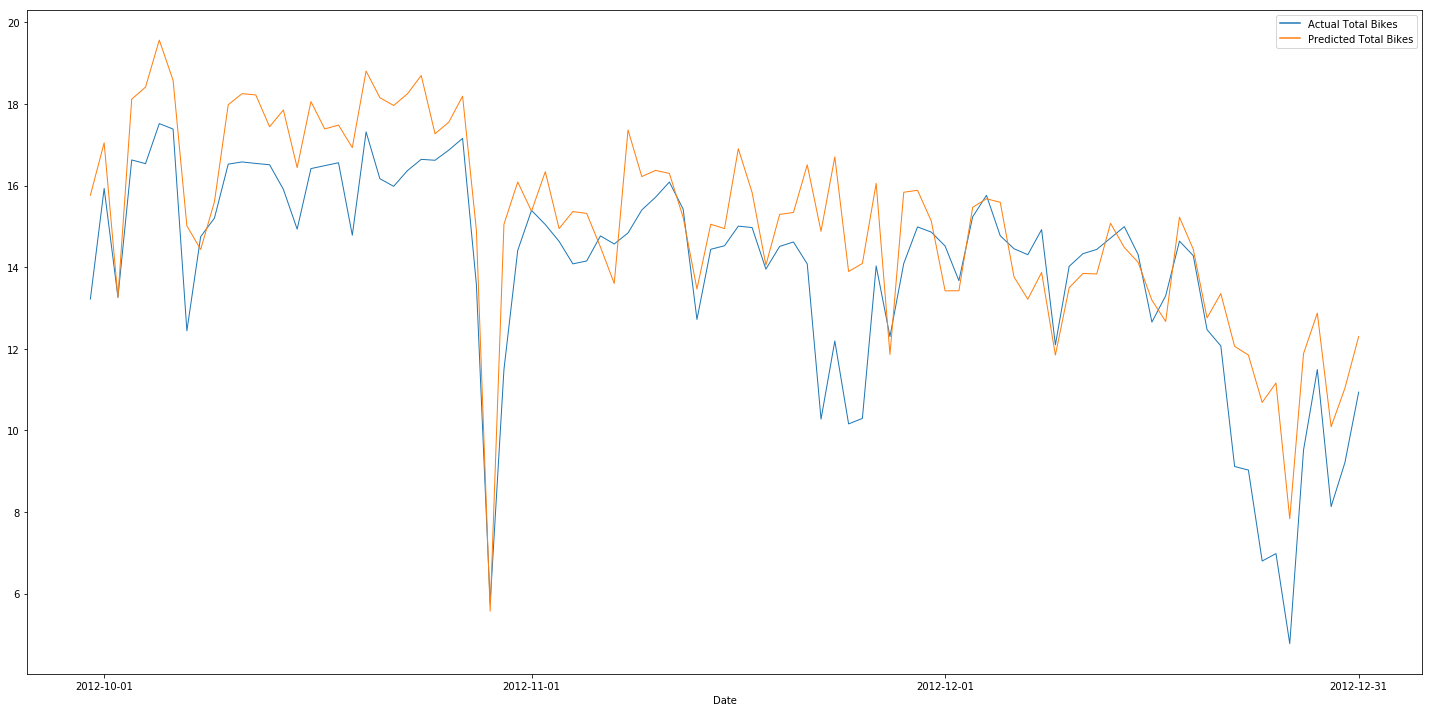

In [131]:
y_test_prep = pd.concat([y_test_count,pd.DataFrame(pd.DatetimeIndex(first_hour_data['dteday']).strftime('%Y-%m-%d'))],
                         axis=1,
                         sort=False, 
                         ignore_index=False)

y_test_prep = y_test_prep.dropna()
y_test_prep = y_test_prep.set_index(0)
y_pred_prep = pd.DataFrame(pred_summed)
y_total_prep = pd.concat([y_test_prep.reset_index(drop=False), y_pred_prep.reset_index(drop=True)], axis=1)
y_total_prep.columns = ['Date', 'Actual Total Bikes', 'Predicted Total Bikes']
y_total_prep = y_total_prep.set_index('Date')
        
plt.figure(figsize=(20,10))
g = sns.lineplot(data=y_total_prep, ci=None, lw=1, dashes=False)
g.set_xticks(['2012-10-01', '2012-11-01', '2012-12-01', '2012-12-31'])
g.legend(loc='upper right', ncol=1)
plt.tight_layout()

## II) Splitting by workdays and predicting 4 times

As an additional splitting we want to investigate the increase of our score when bikes our rented in the weekend or during the week. Therefore, we performed an additional split, keeping the weekends and workdays for casual and registered demand seperated in four datasets. In the end they will all four be ensembled and the score will be derived.

Splitting

In [43]:
workdays = hour_data_FE_hot_encoded[hour_data_FE_hot_encoded.workingday_1 == 1]
weekends = hour_data_FE_hot_encoded[hour_data_FE_hot_encoded.workingday_1 == 0]

### a) Modeling for Registered Workdays

In [44]:
x_train_reg_wd, x_test_reg_wd, y_train_reg_wd, y_test_reg_wd = split_data(workdays, "registered")

In [45]:
train_reg_wd_dropped_target = x_train_reg_wd.drop(["casual", "count"], axis = 1)
test_reg_wd_dropped_target = x_test_reg_wd.drop(["casual", "count"], axis = 1)

## scoring Registered Workdays
for model in models:
    score_one_model(train_reg_wd_dropped_target, test_reg_wd_dropped_target, y_train_reg_wd, y_test_reg_wd, model)

Linear Regression
Mean squared error (MSE): 5.62
Variance score (R2): 0.87
----------------------------

Ridge
Mean squared error (MSE): 5.63
Variance score (R2): 0.87
----------------------------

Huber Regressors
Mean squared error (MSE): 18.63
Variance score (R2): 0.56
----------------------------

Descicion Tree Regressor
Mean squared error (MSE): 6.85
Variance score (R2): 0.84
----------------------------

Extra Trees Regressor
Mean squared error (MSE): 5.22
Variance score (R2): 0.88
----------------------------

Gradient Boosting Regressor
Mean squared error (MSE): 6.50
Variance score (R2): 0.85
----------------------------

Random Forest Regressor
Mean squared error (MSE): 5.21
Variance score (R2): 0.88
----------------------------

BaggingRegressor
Mean squared error (MSE): 5.54
Variance score (R2): 0.87
----------------------------



Extra Trees Regressor gives us the best score with 0.88 / 0.89

_(Note for Report all scores increased after splitting by workday)_

In [68]:
reg_wd_pred = score_one_model(train_reg_wd_dropped_target, test_reg_wd_dropped_target, y_train_reg_wd, y_test_reg_wd,
                  models[4]) ## 4 is the index of Extra Trees Regressor in models array

Extra Trees Regressor
Mean squared error (MSE): 4.87
Variance score (R2): 0.89
----------------------------



### b) Modeling for Registered Weekends

In [47]:
x_train_reg_we, x_test_reg_we, y_train_reg_we, y_test_reg_we = split_data(weekends, "registered")

In [48]:
train_reg_we_dropped_target = x_train_reg_we.drop(["casual", "count"], axis = 1)
test_reg_we_dropped_target = x_test_reg_we.drop(["casual", "count"], axis = 1)


## scoring Registered Workdays
for model in models:
    score_one_model(train_reg_we_dropped_target, test_reg_we_dropped_target, y_train_reg_we, y_test_reg_we, model)

Linear Regression
Mean squared error (MSE): 5.69
Variance score (R2): 0.80
----------------------------

Ridge
Mean squared error (MSE): 5.71
Variance score (R2): 0.80
----------------------------

Huber Regressors
Mean squared error (MSE): 10.45
Variance score (R2): 0.63
----------------------------

Descicion Tree Regressor
Mean squared error (MSE): 12.72
Variance score (R2): 0.55
----------------------------

Extra Trees Regressor
Mean squared error (MSE): 5.83
Variance score (R2): 0.79
----------------------------

Gradient Boosting Regressor
Mean squared error (MSE): 8.30
Variance score (R2): 0.71
----------------------------

Random Forest Regressor
Mean squared error (MSE): 8.54
Variance score (R2): 0.70
----------------------------

BaggingRegressor
Mean squared error (MSE): 7.82
Variance score (R2): 0.72
----------------------------



Linear Regression is the best score with 0.80

In [49]:
reg_we_pred = score_one_model(train_reg_we_dropped_target, test_reg_we_dropped_target, y_train_reg_we, y_test_reg_we,
                  models[0])

Linear Regression
Mean squared error (MSE): 5.69
Variance score (R2): 0.80
----------------------------



### c) Modeling for Casual Workdays

In [50]:
x_train_casual_wd, x_test_casual_wd, y_train_casual_wd, y_test_casual_wd = split_data(workdays, "casual")

In [51]:
train_cas_wd_dropped_target = x_train_casual_wd.drop(["registered", "count"], axis = 1)
test_cas_wd_dropped_target = x_test_casual_wd.drop(["registered", "count"], axis = 1)


## scoring Registered Workdays
for model in models:
    score_one_model(train_cas_wd_dropped_target, test_cas_wd_dropped_target, y_train_casual_wd, y_test_casual_wd, model)

Linear Regression
Mean squared error (MSE): 0.66
Variance score (R2): 0.81
----------------------------

Ridge
Mean squared error (MSE): 0.66
Variance score (R2): 0.81
----------------------------

Huber Regressors
Mean squared error (MSE): 1.30
Variance score (R2): 0.62
----------------------------

Descicion Tree Regressor
Mean squared error (MSE): 1.30
Variance score (R2): 0.62
----------------------------

Extra Trees Regressor
Mean squared error (MSE): 1.91
Variance score (R2): 0.45
----------------------------

Gradient Boosting Regressor
Mean squared error (MSE): 0.93
Variance score (R2): 0.73
----------------------------

Random Forest Regressor
Mean squared error (MSE): 1.01
Variance score (R2): 0.71
----------------------------

BaggingRegressor
Mean squared error (MSE): 0.94
Variance score (R2): 0.73
----------------------------



Linear Regression is the best score with 0.81

In [52]:
casual_wd_pred = score_one_model(train_cas_wd_dropped_target, test_cas_wd_dropped_target, y_train_casual_wd, y_test_casual_wd,
                  models[0])

Linear Regression
Mean squared error (MSE): 0.66
Variance score (R2): 0.81
----------------------------



### d) Modeling for Casual Weekends

In [53]:
x_train_casual_we, x_test_casual_we, y_train_casual_we, y_test_casual_we = split_data(weekends, "casual")

In [54]:
train_cas_we_dropped_target = x_train_casual_we.drop(["registered", "count"], axis = 1)
test_cas_we_dropped_target = x_test_casual_we.drop(["registered", "count"], axis = 1)


## scoring Registered Workdays
for model in models:
    score_one_model(train_cas_we_dropped_target, test_cas_we_dropped_target, y_train_casual_we, y_test_casual_we, model)

Linear Regression
Mean squared error (MSE): 0.68
Variance score (R2): 0.86
----------------------------

Ridge
Mean squared error (MSE): 0.68
Variance score (R2): 0.86
----------------------------

Huber Regressors
Mean squared error (MSE): 1.71
Variance score (R2): 0.65
----------------------------

Descicion Tree Regressor
Mean squared error (MSE): 2.24
Variance score (R2): 0.54
----------------------------

Extra Trees Regressor
Mean squared error (MSE): 0.91
Variance score (R2): 0.81
----------------------------

Gradient Boosting Regressor
Mean squared error (MSE): 1.07
Variance score (R2): 0.78
----------------------------

Random Forest Regressor
Mean squared error (MSE): 1.18
Variance score (R2): 0.76
----------------------------

BaggingRegressor
Mean squared error (MSE): 1.09
Variance score (R2): 0.77
----------------------------



Linear Regression is the best score with 0.86

In [55]:
casual_we_pred = score_one_model(train_cas_we_dropped_target, test_cas_we_dropped_target, y_train_casual_we, y_test_casual_we,
                  models[0])

Linear Regression
Mean squared error (MSE): 0.68
Variance score (R2): 0.86
----------------------------



### e) Final summed score after splitting by Workdays/Weekends

In [56]:
we_pred_summed = reg_we_pred + casual_we_pred
wd_pred_summed = reg_wd_pred + casual_wd_pred

In [57]:
predictions = np.concatenate([we_pred_summed, wd_pred_summed])

In [58]:
target = pd.concat([x_test_casual_we["count"], x_test_casual_wd["count"]])

In [59]:
print(
    "Mean squared error (MSE): {}".format(mean_squared_error(target, predictions))
)
print("Variance score (R2): {}".format(r2_score(predictions, target)))

Mean squared error (MSE): 8.357831884461495
Variance score (R2): 0.8353526395286948


### f) Plotting results

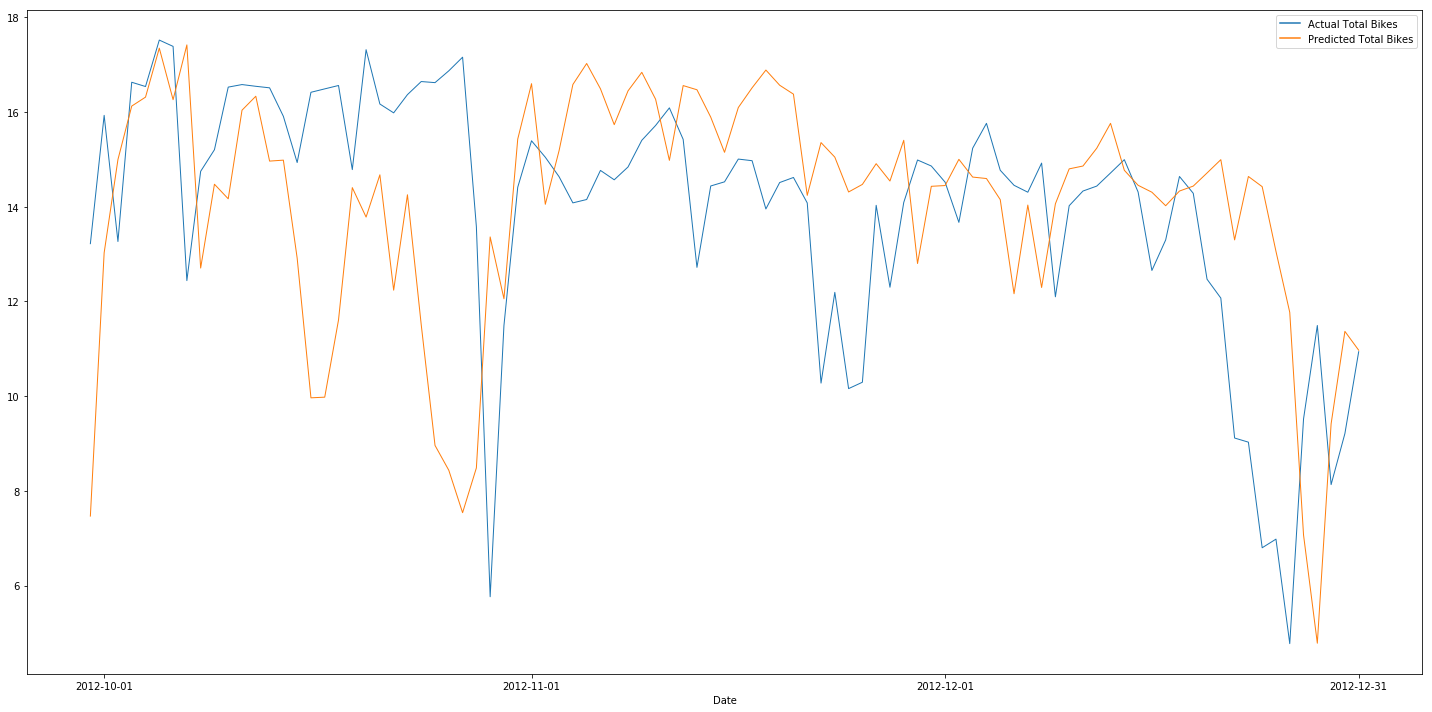

In [130]:
y_test_prep = pd.concat([y_test_count,pd.DataFrame(pd.DatetimeIndex(first_hour_data['dteday']).strftime('%Y-%m-%d'))],
                         axis=1,
                         sort=False, 
                         ignore_index=False)

y_test_prep = y_test_prep.dropna()
y_test_prep = y_test_prep.set_index(0)
y_pred_prep = pd.DataFrame(target)
y_total_prep = pd.concat([y_test_prep.reset_index(drop=False), y_pred_prep.reset_index(drop=True)], axis=1)
y_total_prep.columns = ['Date', 'Actual Total Bikes', 'Predicted Total Bikes']
y_total_prep = y_total_prep.set_index('Date')
        
plt.figure(figsize=(20, 10))
g = sns.lineplot(data=y_total_prep, ci=None, lw=1, dashes=False)
g.set_xticks(['2012-10-01', '2012-11-01', '2012-12-01', '2012-12-31'])
g.legend(loc='upper right', ncol=1)
plt.tight_layout()

Unfortunately this second approach of splitting and binning does not improve our final score. Although the scores for splits with weekend days both improved for casual and registered, the ones for weekdays decreased. This is probably due to the pattern during the weekdays that occur more in hours instead of in days.

# 8. Conclusions

We choose to go with the ensemble model we created in I.c, giving us a score of an ensemble of a Linear Model and untuned Extra Trees Regressor of 88%. Opportunities to improve the higher score we aimed to get in II.e, we could get by tuning the parameters of our best performing model. Also binning the hours in the weekdays as an additional feature could improve the score of this split and thus result in a higher accuracy score.